# 3. Phân tích số lượt cảm xúc

In [44]:
%store -r clean_df

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from facebook_scraper import *
from geopy.geocoders import Nominatim
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

## 3.1 Tương quan giữa thời gian đăng và số lượng cảm xúc

### 3.1.1 Giờ đăng và tổng số lượt cảm xúc

In [46]:
clean_df['time'] = pd.to_datetime(clean_df['time'], format='%Y-%m-%d %H:%M:%S')
clean_df['hour'] = clean_df['time'].dt.hour
clean_df['month'] = clean_df['time'].dt.month

In [47]:
df = clean_df[['reaction_count', 'hour']]
# Khi nhóm thì cột hour thành chỉ mục nên phải chuyển nó thành cột bằng reset_index()
df_hour= df.groupby('hour').sum().reset_index()
fig = px.bar(df_hour, x='hour', y='reaction_count', title='Reactions per hour')
fig.show()

### 3.1.2 Số lượng bài đăng vào từng khung giờ

In [48]:
clean_df['hour'].value_counts().reset_index()

,hour,count
0,17,45
1,9,33
2,8,10
3,18,9
4,11,8
5,10,6
6,15,5
7,16,3
8,19,3
9,20,2


### 3.1.3 Tổng lượng cảm xúc theo tháng

In [49]:
df = clean_df[['reaction_count', 'month']]
# Khi nhóm thì cột hour thành chỉ mục nên phải chuyển nó thành cột bằng reset_index()
df_hour= df.groupby('month').sum().reset_index()
fig = px.bar(df_hour, x='month', y='reaction_count', title='Reactions per month')

mean_reaction = df['reaction_count'].sum()/12
fig.add_hline(y=mean_reaction, line_color="red", annotation_text="Trung bình", annotation_position="top right")

fig.show()

### 3.1.4 Tổng số bài đăng theo tháng

In [50]:
clean_df['month'].value_counts().reset_index()

,month,count
0,9,25
1,1,23
2,7,16
3,10,14
4,4,13
5,3,12
6,11,10
7,5,5
8,8,4
9,12,4


### 3.1.5 Số bài đăng và tổng lượt reaction trong thứ

In [51]:
clean_df['weekday'] = clean_df['time'].dt.dayofweek

def map_day_to_vietnamese(day):
    weekdays = {
        0: 'Thứ Hai',
        1: 'Thứ Ba',
        2: 'Thứ Tư',
        3: 'Thứ Năm',
        4: 'Thứ Sáu',
        5: 'Thứ Bảy',
        6: 'Chủ Nhật'
    }
    return weekdays[day]

# Áp dụng hàm ánh xạ để tạo cột 'weekday_name'
clean_df['weekday_name'] = clean_df['weekday'].apply(map_day_to_vietnamese)
px.funnel(clean_df['weekday_name'].value_counts().reset_index(), x = 'weekday_name', y = 'count')

In [52]:
df_wd = clean_df[['reaction_count', 'weekday']]
# Khi nhóm thì cột hour thành chỉ mục nên phải chuyển nó thành cột bằng reset_index()
df_wd= df_wd.groupby('weekday').sum().reset_index()
df_wd['weekday_name'] = df_wd['weekday'].apply(map_day_to_vietnamese)
fig = px.bar(df_wd, x='weekday_name', y='reaction_count', title='Reactions per weekday')
fig.show()

## 3.2 Cảm xúc trong hơn 100 bài mới nhất

In [53]:
px.bar(clean_df, y='reaction_count').show()

## 3.2.2 Dự đoán số lượt cảm xúc từ mô hình học máy

In [54]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train, test = train_test_split(clean_df, train_size=0.8)

# Huấn luyện mô hình ARIMA
model = pm.auto_arima(train['reaction_count'], seasonal=True, m=12)

# Dự đoán giá trị cho 2 ngày tiếp theo
predictions = model.predict(n_periods=7)

print(predictions)

102    1501.679303
103    1332.334495
104    1369.759103
105    1431.771588
106    1422.451948
107    4446.152211
108    1754.068849
dtype: float64


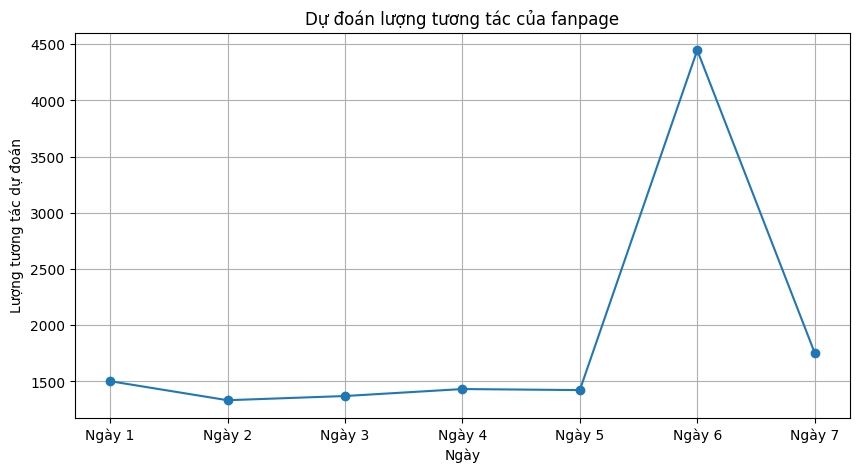

In [55]:
dates = ['Ngày 1', 'Ngày 2', 'Ngày 3', 'Ngày 4', 'Ngày 5', 'Ngày 6', 'Ngày 7']

plt.figure(figsize=(10, 5))
plt.plot(dates, predictions, marker='o')
plt.title('Dự đoán lượng tương tác của fanpage')
plt.xlabel('Ngày')
plt.ylabel('Lượng tương tác dự đoán')
plt.grid(True)
plt.show()

## 3.3 Loại cảm xúc của các bài đăng

In [56]:
import ast
reactions_list = []

for post in clean_df['reactions']:
    reactions_list.append(ast.literal_eval(post))

reactions_df = pd.DataFrame(reactions_list)

reactions_summary = reactions_df.sum().reset_index()
reactions_summary.columns = ['emotion', 'count']

print(reactions_summary)

         emotion     count
0          thích  142968.0
1      yêu thích   78644.0
2           haha   10616.0
3            wow    6949.0
4  thương thương    3081.0
5           buồn    5193.0
6        phẫn nộ     104.0


In [57]:
fig = px.line_polar(reactions_summary, r='count', theta='emotion', line_close=True)

# Hiển thị biểu đồ
fig.show()

## 3.4 Số người tiếp cận trong mỗi loại file

In [58]:
def classify_post(row):
    if not pd.isnull(row['video']) and not pd.isnull(row['image']):
        return 'Video và Hình Ảnh'
    elif not pd.isnull(row['video']) and pd.isnull(row['image']):
        return 'Chỉ Video'
    elif not pd.isnull(row['image']):
        return 'Chỉ Hình Ảnh'
    else:
        return 'Chỉ Văn Bản'

clean_df['post_type'] = clean_df.apply(classify_post, axis=1)

fig = px.line(clean_df, x='time', y='reaction_count', color='post_type')

fig.update_layout(
    title='Biểu đồ số lượng cảm xúc phụ thuộc vào loại bài đăng theo thời gian',
    xaxis_title='Thời Gian',
    yaxis_title='Số Lượng Reaction',
    legend_title='Loại Bài Đăng'
)

# Hiển thị biểu đồ
fig.show()